# word2vec and random forest classification

Analysis of the [Amazon Fine Food Reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews).
GitHub repository with this analysis: https://github.com/JungeAlexander/kaggle-amazon-fine-food-reviews

**Summary:** The goal of the analysis is to classify positive (4-5 stars) and negative (1-2 stars) reviews based on the
review content. Prior to classification using a random forest, vector representations (aka word embeddings)
are learned using [word2vec](https://www.tensorflow.org/versions/r0.12/tutorials/word2vec/index.html). After exploring these word embeddings a little bit, the embeddings are used to map each review to a feature vector.
These feature vectors are then used in the classfication task.

---

Some inspiration for this notebook can be found here:

- https://www.kaggle.com/c/word2vec-nlp-tutorial
- https://www.kaggle.com/gpayen/d/snap/amazon-fine-food-reviews/building-a-prediction-model/notebook
- https://www.kaggle.com/inspector/d/snap/amazon-fine-food-reviews/word2vec-logistic-regression-0-88-auc/notebook

In [1]:
from gensim.models import Word2Vec, word2vec
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import sqlite3
import re
from tqdm import tqdm

/home/ajunge/local/anaconda3/envs/kaggle-amazon-fine-food-reviews/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [2]:
logging.basicConfig(level=logging.INFO)
%matplotlib inline

In [3]:
# Load the punkt tokenizer used for splitting reviews into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Labelling good and bad reviews

To obtain binary class labels, reviews with 4-5 stars are considered good and assigned a '1' class label while reviews with less than 3 stars are considered bad and assigned a '0' class label. Reviews with 3 stars are ignored.

In [4]:
connection = sqlite3.connect('../input/database.sqlite')
reviews = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", connection)
connection.close()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b4cdc21d0>]], dtype=object)

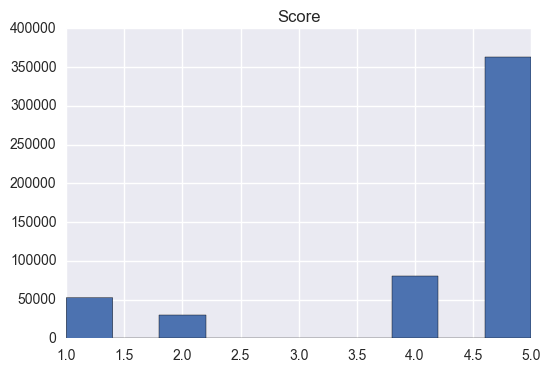

In [5]:
reviews.hist('Score')

We observe that the data set is heavily skewed towards reviews with a score of 5.

In [6]:
reviews['Class'] = 1 * (reviews['Score'] > 3)

In [7]:
reviews.head(n=2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0


## Split into training and test sets

Split the data set into training and test sets. To ensure indendence of training and test set and generalizability of the model, make sure that no product (identified by `ProductId`) and no user (identified by `UserId`) is present in both training and test set.

This is implemented by first sorting the data set by `ProductId`, splitting into equally sized training and test set (no shuffling!) and lastly removing any reviews from the test set where either user or product ID also appears in the training set. Of course, this will make the training and test sets unequally sized but ¯\\\_\_(ツ)\_\_/¯

In [8]:
reviews.sort_values('ProductId', axis=0, inplace=True)

In [9]:
train_size = int(len(reviews) * 0.5)
train_reviews = reviews.iloc[:train_size,:]
test_reviews = reviews.iloc[train_size:,:]

In [10]:
test_remove = np.logical_or(test_reviews['ProductId'].isin(train_reviews['ProductId']),
                          test_reviews['UserId'].isin(train_reviews['UserId']))
test_reviews = test_reviews[np.logical_not(test_remove)]

In [11]:
print('Training set contains {:d} reviews.'.format(len(train_reviews)))
print('Test set contains {:d} reviews ({:d} removed).'.format(len(test_reviews), sum(test_remove)))

Training set contains 262907 reviews.
Test set contains 151198 reviews (111709 removed).


In [12]:
n_pos_train = sum(train_reviews['Class'] == 1)
print('Training set contains {:.2%} positive reviews'.format(n_pos_train/len(train_reviews)))
n_pos_test = sum(test_reviews['Class'] == 1)
print('Test set contains {:.2%} positive reviews'.format(n_pos_test/len(test_reviews)))

Training set contains 84.93% positive reviews
Test set contains 82.37% positive reviews


In [13]:
del reviews  # hint for garbage collection

## Preparing review text

Convert each review in the training set to a list of sentences where each sentence is in turn a list of words.
Besides splitting reviews into sentences, non-letters and (optionally) stop words are removed and all words
coverted to lower case.

Inspired by: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-2-word-vectors

In [14]:
def review_to_wordlist(review, remove_stopwords=False):
    """
    Convert a review to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words

In [15]:
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    """
    Split review into list of sentences where each sentence is a list of words.
    Removal of stop words is optional.
    """
    # use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())

    # each sentence is furthermore split into words
    sentences = []    
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
            
    return sentences

In [16]:
train_sentences = []  # Initialize an empty list of sentences
for review in train_reviews['Text']:
    train_sentences += review_to_sentences(review, tokenizer)

100%|██████████| 262907/262907 [01:21<00:00, 3239.46it/s]


In [17]:
train_sentences[0]

['this',
 'witty',
 'little',
 'book',
 'makes',
 'my',
 'son',
 'laugh',
 'at',
 'loud']

## Training a word2vec model

In [18]:
model_name = 'train_model'
# Set values for various word2vec parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 3       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words
if not os.path.exists(model_name): 
    # Initialize and train the model (this will take some time)
    model = word2vec.Word2Vec(train_sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model.save(model_name)
else:
    model = Word2Vec.load(model_name)

INFO:gensim.utils:loading Word2Vec object from train_model
INFO:gensim.utils:setting ignored attribute syn0norm to None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:loaded train_model


In [19]:
del train_sentences

The vector representations for words allow us to explore what the model learned. Using the distance between embedded words, we can find that are similar or dissimilar to one another.

In [20]:
model.doesnt_match("banana apple orange sausage".split())

INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


'sausage'

In [21]:
model.doesnt_match("vanilla chocolate cinnamon dish".split())

'dish'

In [22]:
model.most_similar("great")

[('fantastic', 0.7974022030830383),
 ('terrific', 0.778639554977417),
 ('wonderful', 0.7695246934890747),
 ('fabulous', 0.7191793918609619),
 ('good', 0.7056754231452942),
 ('awesome', 0.6772215366363525),
 ('excellent', 0.6546066999435425),
 ('perfect', 0.635776162147522),
 ('superb', 0.6311653852462769),
 ('phenomenal', 0.6143761277198792)]

In [23]:
 model.most_similar("awful")

[('terrible', 0.7411801815032959),
 ('horrible', 0.7315601110458374),
 ('disgusting', 0.6701241731643677),
 ('aweful', 0.6651712656021118),
 ('gross', 0.6525599360466003),
 ('nasty', 0.6149296760559082),
 ('horrid', 0.5932258367538452),
 ('dreadful', 0.5807441473007202),
 ('amazing', 0.5632752776145935),
 ('odd', 0.556433916091919)]

In [24]:
model.most_similar(positive=['woman', 'king'], negative=['man'])

[('charles', 0.48787277936935425),
 ('arthur', 0.4370694160461426),
 ('cavalier', 0.4332427978515625),
 ('george', 0.41141006350517273),
 ('uncle', 0.40545332431793213),
 ('william', 0.4018605947494507),
 ('cocker', 0.3809300363063812),
 ('spaniels', 0.38067492842674255),
 ('spaniel', 0.37925082445144653),
 ('dachshund', 0.3750506043434143)]

In [39]:
model.similar_by_vector(model['beer'] - model['alcohol'])

[('beer', 0.6311907768249512),
 ('cheeze', 0.33028432726860046),
 ('sushi', 0.32479196786880493),
 ('grandma', 0.30367475748062134),
 ('style', 0.30253854393959045),
 ('pizza', 0.2946276366710663),
 ('riesling', 0.28571927547454834),
 ('pho', 0.2851570248603821),
 ('bbq', 0.28422197699546814),
 ('sandwiches', 0.28153371810913086)]

## Build classifier using word embedding

Inspiration: https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-3-more-fun-with-word-vectors

Each review is mapped to a feature vector by averaging the word embeddings of all words in the review. These features are then fed into a random forest classifier.

In [24]:
model.syn0.shape

(10821, 300)

In [25]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0.
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1.
    return review_feature_vecs

In [26]:
# calculate average feature vectors for training and test sets
clean_train_reviews = []
for review in train_reviews['Text']:
    clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)

100%|██████████| 262907/262907 [03:24<00:00, 1283.61it/s]


In [27]:
clean_test_reviews = []
for review in test_reviews['Text']:
    clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

100%|██████████| 151198/151198 [01:58<00:00, 1281.31it/s]


In [28]:
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, train_reviews['Class'])

Fitting a random forest to labeled training data...


In [29]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    test_reviews.drop(test_reviews.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(test_reviews)

Removing 1 instances from test set.


In [30]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

Predicting labels for test data..


In [31]:
print(classification_report(test_reviews['Class'], result))

             precision    recall  f1-score   support

          0       0.85      0.31      0.45     26651
          1       0.87      0.99      0.93    124546

avg / total       0.87      0.87      0.84    151197



While precision looks okay for both negative and positive reviews, recall is only acceptable for positive reviews.

Finally, compute ROC curve and area under the curve.

In [32]:
probs = forest.predict_proba(testDataVecs)[:, 1]

fpr, tpr, _ = roc_curve(test_reviews['Class'], probs)
auc = roc_auc_score(test_reviews['Class'], probs)

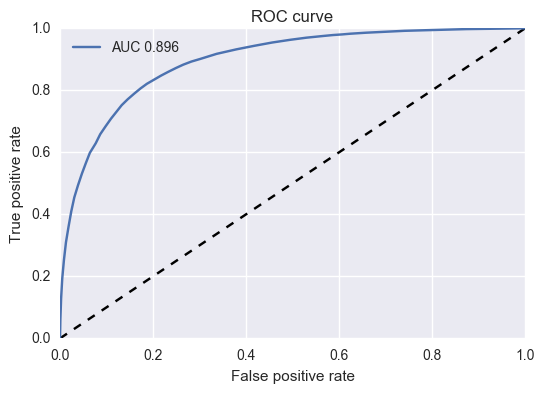

In [33]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Some ideas for further analyses

- Does using a class-balanced training set increase the classification performance?
- Parameter tuning for word2vec and random forest (using K-fold cross-validation with small K as training lots of embeddings and classifiers is expensive?)
- Remove reviews where too few word embeddings were averaged (see the example that had to be removed)?
- How would a classifier with tf-idf features (and no word2vec embedding) perform?
- Other model: naive bayes (`MultinomialNB`)? SVM (`SGDClassifier`)?

## Random forest classifier without word2vec

Instead of word2vec-derived features, the classifier below uses as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)-derived feature matrix as input to a random forest classifier.
We see that F1-score is worse for both classes, compared to the word2vec approach.

In [40]:
# from sklearn.naive_bayes import MultinomialNB
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB)])

# from sklearn.linear_model import SGDClassifier
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42))])
                     
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators = 100))])

In [41]:
_ = text_clf.fit(train_reviews['Text'], train_reviews['Class'])

In [42]:
predicted = text_clf.predict(test_reviews['Text'])

In [43]:
print(classification_report(test_reviews['Class'], predicted))

             precision    recall  f1-score   support

          0       0.98      0.12      0.21     26651
          1       0.84      1.00      0.91    124547

avg / total       0.87      0.84      0.79    151198



In [44]:
print(confusion_matrix(test_reviews['Class'], predicted))

[[  3096  23555]
 [    50 124497]]
